# Sheet 1

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

from numpy import linalg as LA

%matplotlib inline

## 1 Principal Component Analysis
### (a)

In [50]:
# implement PCA (fill in the blanks in the function below)


def pca(data, n_components=None):
    """
    Principal Component Analysis on a p x N data matrix.

    Parameters
    ----------
    data : np.ndarray
        Data matrix of shape (p, N).
    n_components : int, optional
        Number of requested components. By default returns all components.

    Returns
    -------
    np.ndarray, np.ndarray
        the pca components (shape (n_components, p)) and the projection (shape (n_components, N))

    """
    # set n_components to p by default
    n_components = data.shape[0] if n_components is None else n_components
    assert (
        n_components <= data.shape[0]
    ), f"Got n_components larger than dimensionality of data!"

    # center the data
    mean = np.mean(data, axis=1, keepdims=True)
    X = data - mean

    # compute X times X transpose
    covmat = X @ X.T

    # compute the eigenvectors and eigenvalues
    eigval, eigvec = LA.eig(covmat)
    # WARN: complex values

    # sort the eigenvectors by eigenvalue and take the n_components largest ones
    indices = np.argsort(abs(eigval))
    # weirdly, numpy docs don't tell us if the it's decreasing or increasing:
    if abs(eigval[indices[0]]) < abs(eigval[indices[-1]]):
        indices = indices[::-1]
    indices = indices[:n_components]
    components = np.real_if_close(eigvec[:, indices].T)
    eigval = np.real_if_close(eigval[indices])
    assert np.issubdtype(components.dtype, np.floating)
    assert np.all(eigval > 0)

    # compute X_projected, the projection of the data to the components
    X_projected = components @ X

    return (
        components,
        X_projected,
    )  # return the n_components first components and the pca projection of the data

In [51]:
# Example data to test your implementation
# All the asserts on the bottom should go through if your implementation is correct

data = np.array(
    [[1, 0, 0, -1, 0, 0], [0, 3, 0, 0, -3, 0], [0, 0, 5, 0, 0, -5]], dtype=np.float32
)

# add a random offset to all samples. it should not affect the results
data += np.random.randn(data.shape[0], 1)

n_components = 2
components, projection = pca(
    data, n_components=n_components
)  # apply your implementation

# the correct results are known (up to some signs)
true_components = np.array([[0, 0, 1], [0, 1, 0]], dtype=np.float32)
true_projection = np.array([[0, 0, 5, 0, 0, -5], [0, 3, 0, 0, -3, 0]], dtype=np.float32)

# check that components match, up to sign
assert isinstance(
    components, np.ndarray
), f"Expected components to be numpy array but got {type(components)}"
assert (
    components.shape == true_components.shape
), f"{components.shape}!={true_components.shape}"
assert np.allclose(
    np.abs(components * true_components).sum(1), np.ones(n_components)
), f"Components not matching"

# check that projections agree, taking into account potentially flipped components
assert isinstance(
    projection, np.ndarray
), f"Expected projection to be numpy array but got {type(projection)}"
assert projection.shape == (
    n_components,
    data.shape[1],
), f"Incorrect shape of projection: Expected {(n_components, data.shape[1])}, got {projection.shape}"
assert np.allclose(
    projection,
    true_projection * (components * true_components).sum(1, keepdims=True),
    atol=1e-6,
), f"Projections not matching"

print("Test successful!")

Test successful!


### (b)

Load the data (it is a subset of the data at https://opendata.cern.ch/record/4910#)

In [52]:
features = np.load("data/dijet_features.npy")
labels = np.load("data/dijet_labels.npy")
label_names = ["b", "c", "q"]  # bottom, charm or light quarks

print(f"{features.shape=}, {labels.shape=}")  # print the shapes

# print how many samples of each class are present in the data (hint: numpy.unique)
labels = np.array(labels, dtype=np.int8)
unique_labels = np.unique(labels)
print(f"{len(unique_labels)} unique labels: {unique_labels}")

features.shape=(116, 2233), labels.shape=(2233,)
3 unique labels: [0 1 2]


Normalize the data

In [53]:
# report range of features and normalize the data to zero mean and unit variance
feat_ranges = features.max(axis=1) - features.min(axis=1)
print(f"{min(feat_ranges)=}; {max(feat_ranges)=}")
normalized = features - np.mean(features, axis=1, keepdims=True)
normalized = normalized / np.std(features, axis=1, keepdims=True)

min(feat_ranges)=0.021708244174450164; max(feat_ranges)=2576772.606923904


### (c)
Compute a 2D PCA projection and make a scatterplot of the result, once without color, once coloring the dots by label. Interpret your results.

In [54]:
# apply PCA as implemented in (a)
components, projection = pca(normalized, n_components=2)

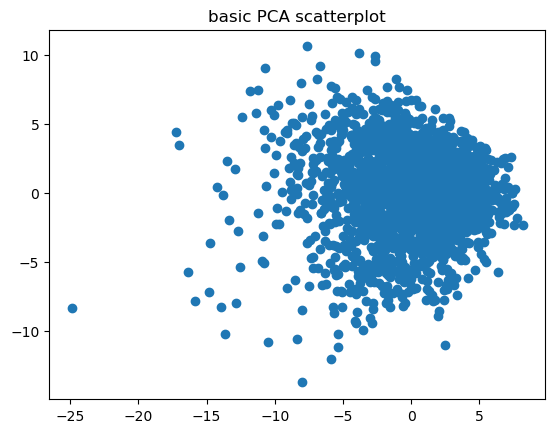

In [55]:
# make a scatterplot of the PCA projection
plt.scatter(projection[0, :], projection[1, :])
plt.title("basic PCA scatterplot")
plt.show()

here we can only see a single cluster, thus the visualization is pretty useless

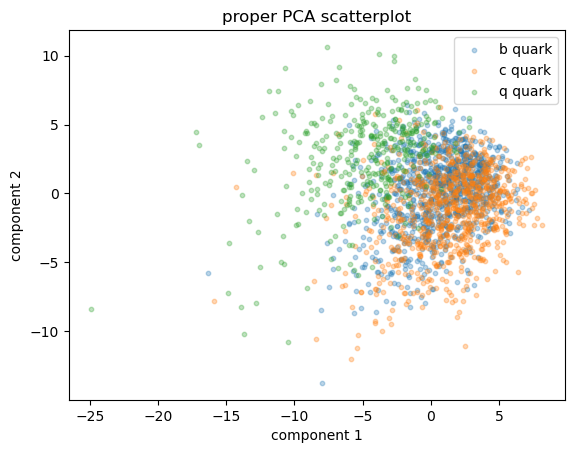

In [56]:
# make a scatterplot, coloring the dots by their label and including a legend with the label names
# (hint: one way is to call plt.scatter once for each of the three possible labels. Why could it be problematic to scatter the data sorted by labels though?)


def scatter(projection, title="some cern data"):
    plt.figure()
    # figsize=(12,12)
    for label in unique_labels:
        indices = labels == label
        plt.scatter(
            projection[0, indices],
            projection[1, indices],
            label=f"{label_names[label]} quark",
            alpha=0.3,
            s=10,
        )
    plt.xlabel("component 1")
    plt.ylabel("component 2")
    plt.legend()
    plt.title(title)
    plt.show()


scatter(projection, title="proper PCA scatterplot")

this is much better, but still the clusters are overlapping a lot

## 2 Nonlinear Dimension Reduction

In [57]:
import umap  # import umap-learn, see https://umap-learn.readthedocs.io/

In [58]:
# if you have not done 1(b) yet, you can load the normalized features directly:
features = np.load("data/dijet_features_normalized.npy")
labels = np.load("data/dijet_labels.npy")
label_names = ["b", "c", "q"]  # bottom, charm or light quarks

### (a)

In [59]:
# Apply umap on the normalized jet features from excercise 1. It will take a couple of seconds.
# note: umap uses a different convention regarding the feature- and sample dimension, N x p instead of p x N!

reducer = umap.UMAP()
transformed = reducer.fit_transform(features.T)

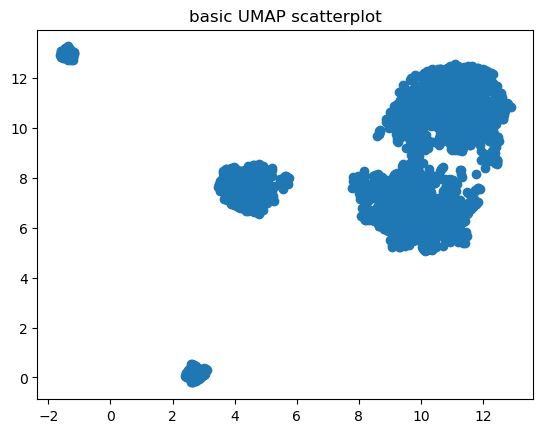

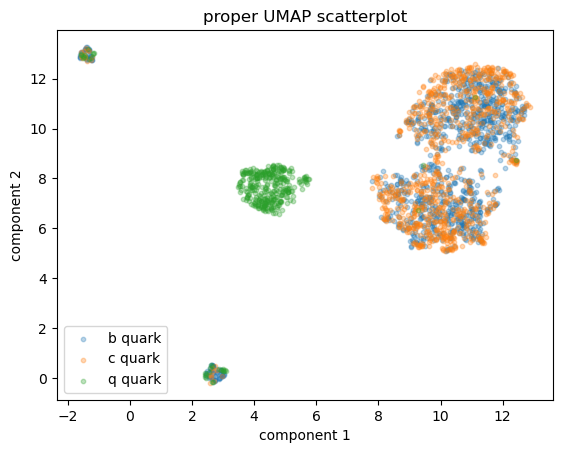

In [60]:
# make a scatterplot of the UMAP projection
plt.scatter(transformed[:, 0], transformed[:, 1])
plt.title("basic UMAP scatterplot")
plt.show()

# make a scatterplot, coloring the dots by their label and including a legend with the label names
scatter(transformed.T, title="proper UMAP scatterplot")

Here we can immediately see much better separation. On the second plot we can see that there is a distinct cluster that only has q quarks in it, and a cluster of c/b quarks.

### (b)

/nix/store/8gl6j62f3nk5dsjcdddvh08cpy32c0xq-python3-3.12.6-env/lib/python3.12/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


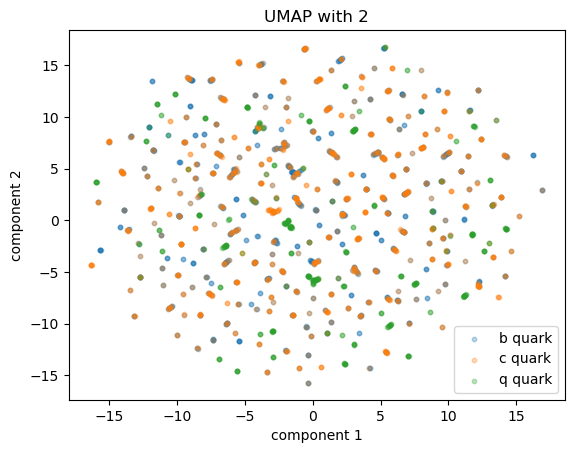

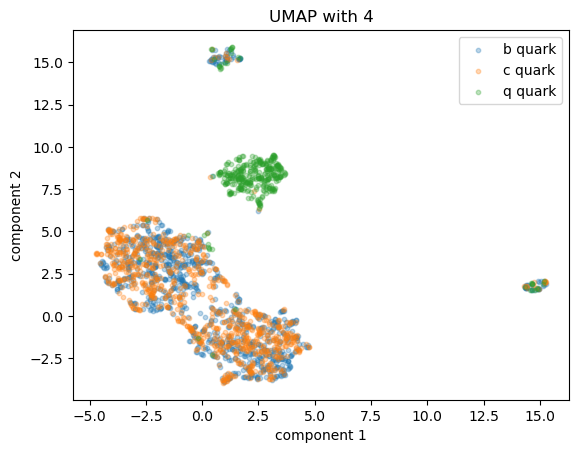

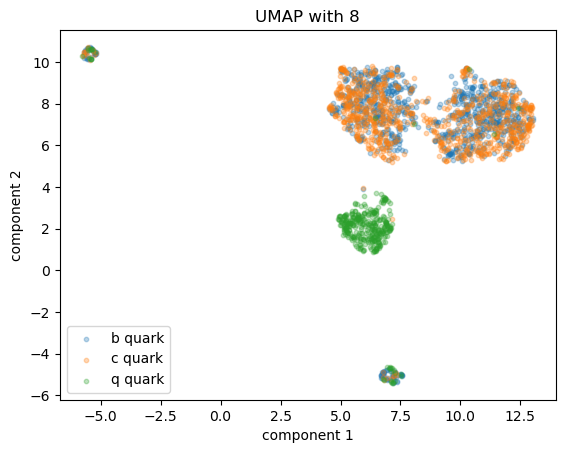

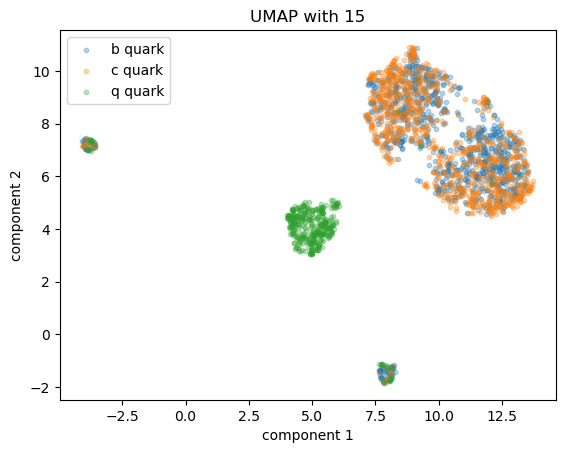

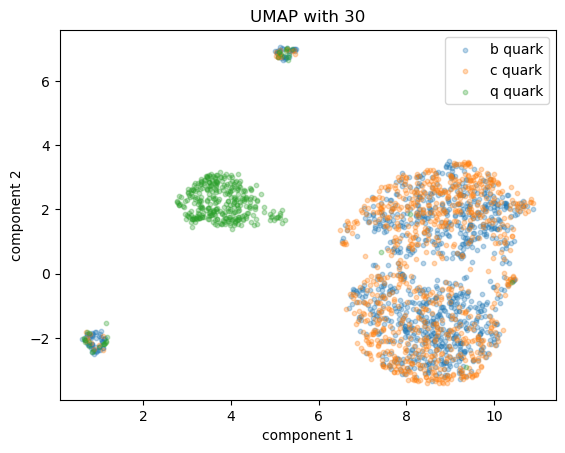

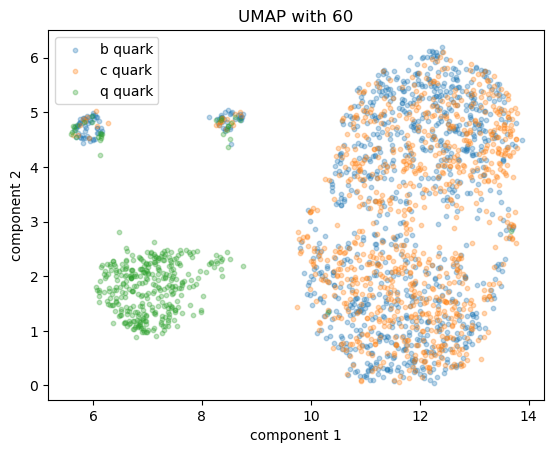

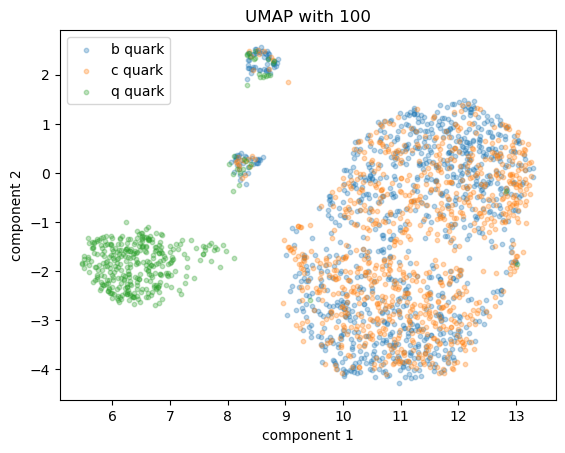

In [61]:
for n_neighbors in (2, 4, 8, 15, 30, 60, 100):
    # repeat the above, varying the n_neighbors parameter of UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    transformed = reducer.fit_transform(features.T)
    scatter(transformed.T, title=f"UMAP with {n_neighbors}")

overall, the general split is the same: q cluster, b/c cluster of a peculiar shape, and two mixed clusters